In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import seaborn as sns
import yfinance as yf
import scipy as scs

In [2]:
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

# Determining the Optimal Portfolio Allocation with Cryptocurrency

**Assumptions:**
1. The investor defines the standard deviation of the asset's returns from their mean (expected return), as a measure of risk.
2. The portfolio risk, $\sigma_{p}$ depends on the variances of assetsin the portfolio and on the covariance between them.
3. The investor allocates the asset's weights in the portfolio to *minimize* the portfolio return risk $\sigma_{p}$ for any desired portfolio expected returns.

In [20]:
# Fetching Data

tickers = "SPY ^RUT BTC-USD EEM TIP VEA TLT BSV DBC VGSLX"
start = "2010-01-01"
end = "2022-09-01"
adj_close = pd.DataFrame(yf.download(tickers, start, end)["Adj Close"])
adj_close.dropna(inplace = True)
adj_close.columns = ["Short Term Bonds", "Bitcoin", "Commodity Index", "Emerging Markets","SPY", "TIPs", "20 Year Bond Fund", "Foreign Equity", "Real Estate", "Russell 2000"]

[*********************100%***********************]  10 of 10 completed


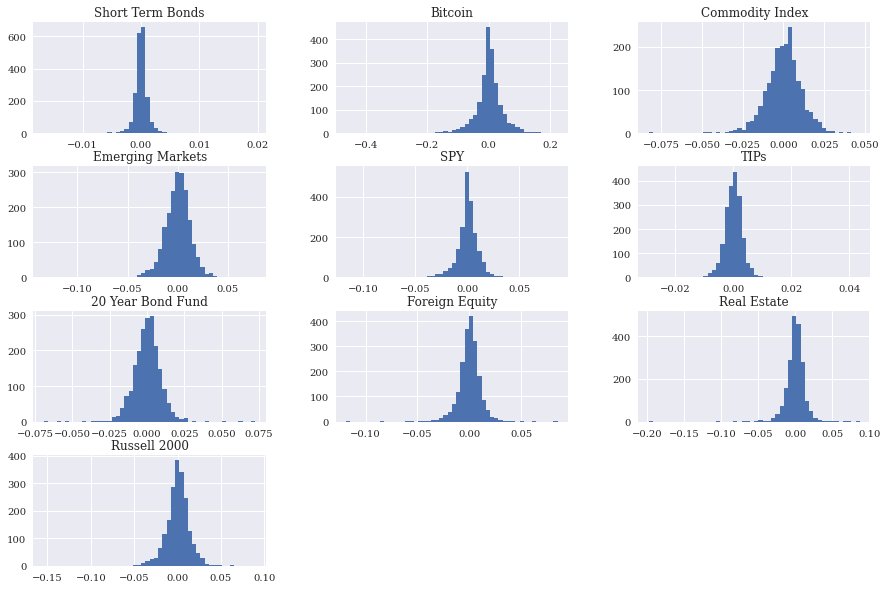

In [38]:
log_returns = np.log(adj_close/adj_close.shift(1))
log_returns.dropna(inplace = True)
log_returns.hist(bins = 50, figsize = (15,10))
noa = 10

<AxesSubplot:xlabel='Date'>

<Figure size 1080x720 with 0 Axes>

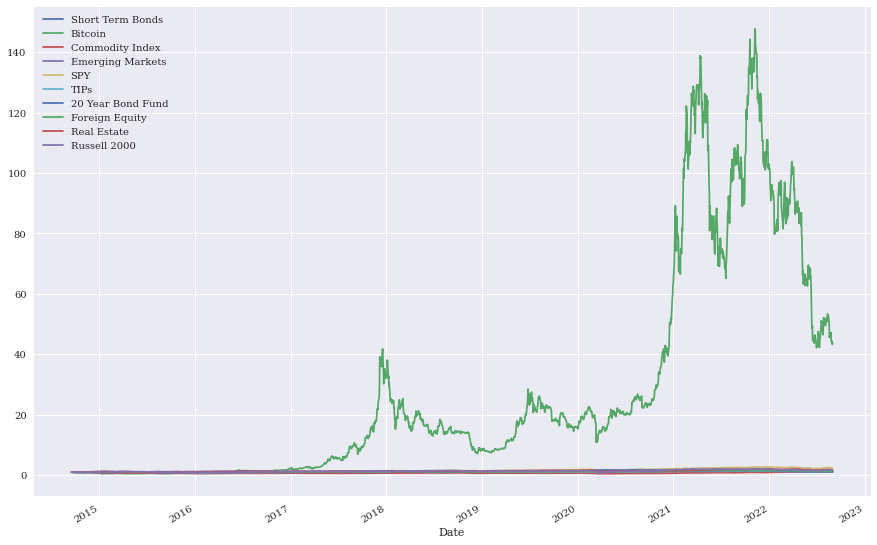

In [87]:
plt.figure(figsize = (15,10))
log_returns.cumsum().apply(np.exp).plot(figsize = (15,10))


In [34]:
log_returns.mean()*252


Short Term Bonds     0.010821
Bitcoin              0.475637
Commodity Index      0.012436
Emerging Markets     0.008344
SPY                  0.103808
TIPs                 0.025323
20 Year Bond Fund    0.020980
Foreign Equity       0.027589
Real Estate          0.067581
Russell 2000         0.058988
dtype: float64

In [31]:
log_returns.cov()*252

,Short Term Bonds,Bitcoin,Commodity Index,Emerging Markets,SPY,TIPs,20 Year Bond Fund,Foreign Equity,Real Estate,Russell 2000
Short Term Bonds,0.000412,0.000265,-0.000174,0.000017,-0.000198,0.000692,0.001733,-0.000038,0.000607,-0.000260
Bitcoin,0.000265,0.539198,0.010000,0.027852,0.027207,0.002036,-0.003486,0.026981,0.022895,0.036234
Commodity Index,-0.000174,0.010000,0.033705,0.016011,0.012131,0.001429,-0.005733,0.013649,0.009463,0.015642
Emerging Markets,0.000017,0.027852,0.016011,0.046992,0.030668,0.000106,-0.007770,0.033253,0.026162,0.036294
SPY,-0.000198,0.027207,0.012131,0.030668,0.033250,-0.000470,-0.008544,0.028588,0.029038,0.037334
TIPs,0.000692,0.002036,0.001429,0.000106,-0.000470,0.003144,0.005687,0.000033,0.001393,-0.000283
20 Year Bond Fund,0.001733,-0.003486,-0.005733,-0.007770,-0.008544,0.005687,0.021159,-0.008106,-0.003294,-0.010554
Foreign Equity,-0.000038,0.026981,0.013649,0.033253,0.028588,0.000033,-0.008106,0.031977,0.025761,0.033964
Real Estate,0.000607,0.022895,0.009463,0.026162,0.029038,0.001393,-0.003294,0.025761,0.045350,0.035743
Russell 2000,-0.000260,0.036234,0.015642,0.036294,0.037334,-0.000283,-0.010554,0.033964,0.035743,0.054225


## Generating Risk-Return Profiles for a given set of financial instruments, and their statistical characteristics

- The goal of this is to implement a Monte Carlo simulation to generate random portfolio weight vectors on a larger scale. 
- For *every simulated allocation*, the code records the resulting expected portfolio return and variance.
- Here I define two functions:
        **port_ret()** and **port_vol**

In [46]:
weights = np.random.random(noa)
weights /= np.sum(weights)


0.9999999999999999

In [53]:
def port_ret(weights):
    return np.sum(log_returns.mean() *weights)*252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T,np.dot(log_returns.cov()*252, weights)))
prets = []
pvols = []
for p in range(5000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)


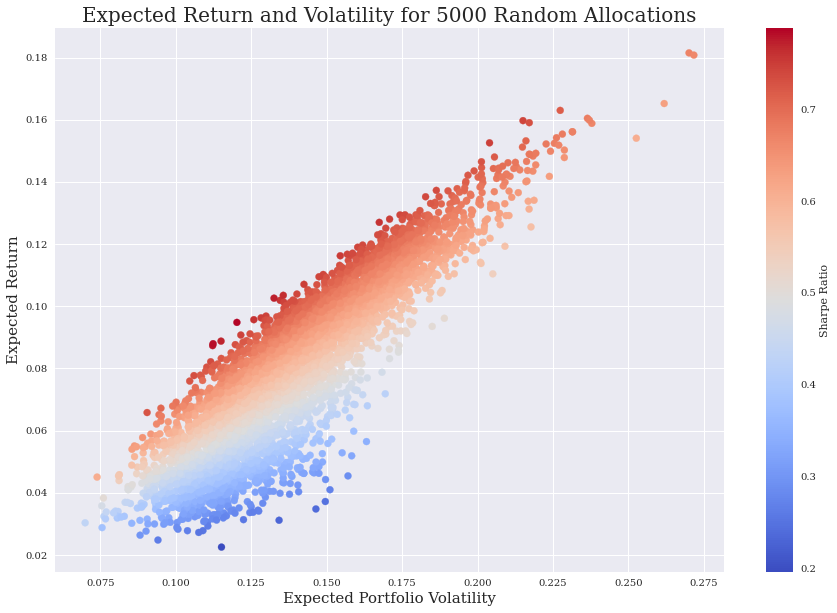

In [58]:
from scipy.ndimage import label


plt.figure(figsize = (15,10))
plt.scatter(pvols, prets, c = prets/pvols,marker = 'o', cmap = "coolwarm")
plt.xlabel("Expected Portfolio Volatility", fontsize = 15)
plt.ylabel("Expected Return", fontsize = 15)
plt.title("Expected Return and Volatility for 5000 Random Allocations", size = 20)
plt.colorbar(label = "Sharpe Ratio")
plt.show()

-It is clear from the picture above that not all weight distributions perform well when measured in terms of mean an volatility. For every fixed level risk, we can see their are multiple portfolios that show different returns. 
- As an investor one is generally interested in the maximum return given a fixed level of risk or the *minimum risk given a fixed return expectation*. 
- This set of portfolios then makes up the so-called **efficient frontier.**

## Optimal Portfolios

-The **minimization** function is general and allows for equality constraints, inequality constraints, and numerical bounds for the parameters. 
-The **maximization of the Sharpe ratio.** Formally, the negative value of the Sharpe ratio is minimized to derive at the maximum value and the optimal portfolio composition. The constraint is that all parameters (weights) add up to 1. This can be formulated using the conventions of the **minimize()** function.The parameters values (weights) are also bound to be between 0 and 1. These values are povided to the minimization function as a tuple of tuples. 

In [62]:
import scipy.optimize as sco

def min_func_sharpe(weights):
    return -port_ret(weights)/port_vol(weights)
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(noa))
eweights = np.array(noa*[1./noa,])
eweights
min_func_sharpe(eweights)

-0.6033009115064529

-Calling the function returns more than just optimal parameter values. THe results are stored in an object called **opts.** 
-The main interest lies in getttin gthe optimmal portfolio composition. 


In [71]:
opts = sco.minimize(min_func_sharpe, eweights, method = "SLSQP", constraints = cons)
pd.DataFrame(opts['x'], index = ["Short Treasury", "Bitcoin", "Commodity", "Emerging Markets", "SPY","TIPs", "20 Year Bonds", "Foreign Equity", "Real Estate", "Russell 2000"], columns = ["Weights"])

,Weights
Short Treasury,0.785345
Bitcoin,0.020773
Commodity,-0.007282
Emerging Markets,-0.067393
SPY,0.404471
TIPs,0.258288
20 Year Bonds,-0.086074
Foreign Equity,-0.170488
Real Estate,-0.046447
Russell 2000,-0.091193


In [78]:
print("The resulting portfolio return and portfolio volatility from the optimal weights are", np.round(port_ret(opts['x']),4), "and",np.round(port_vol(opts["x"]),4), "respectively.")

The resulting portfolio return and portfolio volatility from the optimal weights are 0.0512 and 0.0364 respectively.


- Next, the **Minimization of the Variance of the Portfolio.**This is the same as minimizing the volatility. 

In [80]:
optv = sco.minimize(port_vol, eweights, method = "SLSQP", bounds = bnds, constraints = cons)
pd.DataFrame(optv['x'], index = ["Short Treasury", "Bitcoin", "Commodity", "Emerging Markets", "SPY","TIPs", "20 Year Bonds", "Foreign Equity", "Real Estate", "Russell 2000"], columns = ["Weights"])

,Weights
Short Treasury,9.741494e-01
Bitcoin,0.000000e+00
Commodity,1.241701e-02
Emerging Markets,7.155734e-18
SPY,1.343358e-02
TIPs,0.000000e+00
20 Year Bonds,4.954804e-17
Foreign Equity,3.388132e-17
Real Estate,0.000000e+00
Russell 2000,5.854692e-18
